# Create WecOptTool Model for the Marson WEC concept

In [25]:
import numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import os
import xarray as xr

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

In [26]:
# set frequencies
wCapy =  np.linspace(0.04, 10.0, 100)                  # wave frequencies - also used to specify the lid position

#wCapy =  np.linspace(2*np.pi*1/7.4371, 2*np.pi*2/7.4371, 2)
print(wCapy)

[ 0.04        0.14060606  0.24121212  0.34181818  0.44242424  0.5430303
  0.64363636  0.74424242  0.84484848  0.94545455  1.04606061  1.14666667
  1.24727273  1.34787879  1.44848485  1.54909091  1.64969697  1.75030303
  1.85090909  1.95151515  2.05212121  2.15272727  2.25333333  2.35393939
  2.45454545  2.55515152  2.65575758  2.75636364  2.8569697   2.95757576
  3.05818182  3.15878788  3.25939394  3.36        3.46060606  3.56121212
  3.66181818  3.76242424  3.8630303   3.96363636  4.06424242  4.16484848
  4.26545455  4.36606061  4.46666667  4.56727273  4.66787879  4.76848485
  4.86909091  4.96969697  5.07030303  5.17090909  5.27151515  5.37212121
  5.47272727  5.57333333  5.67393939  5.77454545  5.87515152  5.97575758
  6.07636364  6.1769697   6.27757576  6.37818182  6.47878788  6.57939394
  6.68        6.78060606  6.88121212  6.98181818  7.08242424  7.1830303
  7.28363636  7.38424242  7.48484848  7.58545455  7.68606061  7.78666667
  7.88727273  7.98787879  8.08848485  8.18909091  8.2

-0.09145391140588088
FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_2199"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={"Surge": ..., "Sway": ..., "Heave": ..., "Roll": ..., "Pitch": ..., "Yaw": ...}, center_of_mass=[-5.  0.  0.], name="rect")


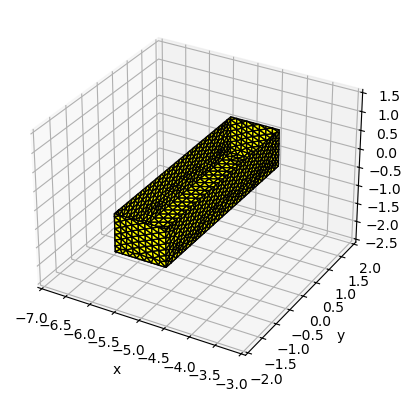

In [27]:
## Input parameters for geometry
numBodies = 1
bodyDist = 10 # distanc between each body's cg
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] # assumes bodies are connected to stationary PTO at x=0
mesh_size_factor = 0.16 # works well for this size 
depth = 2
bodDraft = [1, 1]#, 1]
bodWidth = [1, 1]#, 1]
bodLength = [2, 2]#, 2]

hydrostaticsDict = {}
rect = {}
bodList = [] 

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, depth-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-depth])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lid_pos = meshObj.lowest_lid_position(max(wCapy)) # add lid to reduce irregular frequency peaks
        print(lid_pos)
        lidMesh = meshObj.generate_lid(z=lid_pos)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name="rect", center_of_mass=(bodyLocs[nBod], 0, 0))
        rect[nBod].keep_immersed_part()
        rect[nBod].rotation_center = rect[nBod].center_of_mass
        rect[nBod].add_all_rigid_body_dofs()
        print(rect[nBod])

        bodList.append(rect[nBod])

#all_bodies = cpt.FloatingBody.join_bodies(*bodList)

bodList[0].show_matplotlib()

#all_bodies.show()

In [28]:
### Calculate hydrostatics
myBodies = bodList

for i, body in enumerate(myBodies):
    cg = body.center_of_mass
    # Capytaine version is >= 2.0
    body_hs = body.compute_hydrostatics(rho=1025.0)
    vo = body_hs['disp_volume']
    cb = body_hs['center_of_buoyancy']
    khs = body_hs['hydrostatic_stiffness']

    # Write hydrostatic stiffness to KH.dat file
    khs_full = np.zeros((6,6))
    khs_full[2:5, 2:5] += khs[2:5, 2:5]

    tmp = 'KH.dat'
    np.savetxt(tmp, khs_full)

    # Write the other hydrostatics data to Hydrostatics.dat file
    tmp = 'Hydrostatics.dat'
    f = open(tmp,'w')
    for j in [0,1,2]:
        line =  f'XF = {cb[j]:7.3f} - XG = {cg[j]:7.3f} \n'
        f.write(line)
    line = f'Displacement = {vo:E}'
    f.write(line)
    f.close()

print(khs)

<xarray.DataArray 'hydrostatic_stiffness' (influenced_dof: 6, radiating_dof: 6)> Size: 288B
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.02210000e+04,
        -6.97723129e-13, -1.25590163e-12,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -6.97723129e-13,
         3.34767404e+04, -1.50225583e+00,  1.42893697e-10],
       [ 0.00000000e+00,  0.00000000e+00, -1.25590163e-12,
        -1.50225583e+00, -1.68005738e+04,  2.84322175e-12],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * influenced_dof  (influenced_dof) <U5 120B 'Surge' 'Sway' ... 'Pitch' 'Yaw'
  * radiating_dof   (radiating_dof) <U5 120B 'Surge' 'Sway' ... 'Pitch' 'Yaw'


In [29]:
ncFName = 'attenuator.nc'

path,tmp = os.path.split(os.getcwd() + os.path.sep + ncFName)
path += os.path.sep

headings = np.linspace(0,np.pi/2,1)  

depth = np.infty
density = 1025.0

#print(wCapy)

# call Capytaine solver
print(f'\n-------------------------------\n'
      f'Calling Capytaine BEM solver...\n'
      f'-------------------------------\n'
      f'mesh = {bodList[0].name}\n'
      f'w range = {wCapy[0]:.3f} - {wCapy[-1]:.3f} rad/s\n'
      f'dw = {(wCapy[1]-wCapy[0]):.3f} rad/s\n'
      f'no of headings = {len(headings)}\n'
      f'no of radiation & diffraction problems = {len(wCapy)*(len(headings) + len(bodList[0].dofs))}\n'
      f'-------------------------------\n')

problems = xr.Dataset(coords={
    'omega': wCapy,
    'wave_direction': headings,
    'radiating_dof': list(bodList[0].dofs),
    'water_depth': [depth],
    'rho': [density],
    })

solver = cpt.BEMSolver()
capyData = solver.fill_dataset(problems, [bodList[0]], hydrostatics=False)

# save to .nc file
cpt.io.xarray.separate_complex_values(capyData).to_netcdf(ncFName, encoding={'radiating_dof': {'dtype': 'U'}, 'influenced_dof': {'dtype': 'U'}})

print('\nCapytaine call complete. Data saved to \n' + ncFName +'\n\n')


-------------------------------
Calling Capytaine BEM solver...
-------------------------------
mesh = rect
w range = 0.040 - 10.000 rad/s
dw = 0.101 rad/s
no of headings = 1
no of radiation & diffraction problems = 700
-------------------------------



[08:54:11] WARNING  Mesh resolution for 161 problems:                                                              
                    The resolution of the mesh might be insufficient for omega ranging from 7.787 to 10.000.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Capytaine call complete. Data saved to 
attenuator.nc




In [30]:
print(capyData['hydrostatic_stiffness'])

KeyError: "No variable named 'hydrostatic_stiffness'. Variables on the dataset include ['added_mass', 'radiation_damping', 'g', 'rho', 'body_name', ..., 'Froude_Krylov_force', 'excitation_force', 'period', 'wavenumber', 'wavelength']"

In [ ]:
dataset = xr.open_dataset('attenuator.nc')
print(dataset['added_mass'].values)

[[[ 6.43554559e+03  2.64019830e-01  1.53196719e+00  1.52197099e-02
   -2.74943069e+03 -7.43624031e-01]
  [-1.52784745e-01  9.58332816e+02 -2.88857219e-01  1.21845698e+02
    8.78370190e-02  8.78007383e-01]
  [-1.11614418e+00  1.81630580e-01  2.94395188e+03 -3.46652964e-01
    6.62272359e-01 -1.39917177e-02]
  [-1.31796758e-01  1.21127156e+02 -1.27503368e+00  2.06086234e+03
   -1.19678901e-01  1.31631256e+00]
  [-2.75228137e+03 -2.30981295e-01 -1.84509841e+00 -2.23454282e-01
    1.35690996e+03  4.53327874e-01]
  [-8.84976596e-01 -9.19386180e-01  6.00058296e-01 -9.94829324e-01
    3.66596581e-01  5.29047543e+03]]

 [[ 6.44047479e+03  2.67830317e-01  1.54053271e+00  1.30018285e-02
   -2.75141852e+03 -7.43422159e-01]
  [-1.52828127e-01  9.59135075e+02 -2.92207694e-01  1.21510776e+02
    8.74467760e-02  8.75930716e-01]
  [-1.11702439e+00  1.81925760e-01  2.96379909e+03 -3.46759826e-01
    6.62531078e-01 -1.38552449e-02]
  [-1.31141140e-01  1.20902276e+02 -1.28873097e+00  2.06092748e+03
   -

In [ ]:
dataset = xr.open_dataset('sphere_full.nc')
print(dataset)
print(dataset['added_mass'])

<xarray.Dataset> Size: 326kB
Dimensions:              (omega: 420, radiating_dof: 6, influenced_dof: 6,
                          complex: 2, wave_direction: 1)
Coordinates:
  * omega                (omega) float64 3kB 0.02 0.04 0.06 ... 8.36 8.38 8.4
    body_name            object 8B ...
  * radiating_dof        (radiating_dof) object 48B 'Surge' 'Sway' ... 'Yaw'
  * influenced_dof       (influenced_dof) object 48B 'Surge' 'Sway' ... 'Yaw'
  * complex              (complex) object 16B 're' 'im'
  * wave_direction       (wave_direction) float64 8B 0.0
    g                    float64 8B ...
    rho                  float64 8B ...
    water_depth          float64 8B ...
Data variables:
    added_mass           (omega, radiating_dof, influenced_dof) float64 121kB ...
    radiation_damping    (omega, radiating_dof, influenced_dof) float64 121kB ...
    diffraction_force    (complex, omega, wave_direction, influenced_dof) float64 40kB ...
    Froude_Krylov_force  (complex, omega, wave_dir